In [ ]:
!pip install pyod
import os
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [ ]:
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data', sep='\s+')

data.columns=['mpg','cylinders','displacement','horsepower','weight','acceleration','model year','origin','car name']

data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
1,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
2,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
3,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
4,15.0,8,429.0,198.0,4341.0,10.0,70,1,ford galaxie 500


In [ ]:
data.shape

# number 0 represent the rows and 1 is for columns
print('data has a cardinality size {}'.format(data.shape[0]) + 
      ' and dimensionality size {}'.format(data.shape[1]))

data has a cardinality size 397 and dimensionality size 9


In [ ]:
data.describe()

,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,23.528463,5.448363,193.139798,2969.080605,15.577078,76.025189,1.574307
std,7.820926,1.698329,104.244898,847.485218,2.755326,3.689922,0.802549
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.000000,2223.000000,13.900000,73.000000,1.000000
50%,23.000000,4.000000,146.000000,2800.000000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3609.000000,17.200000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


# Data cleaning and quality check. Using unsupervised anomaly detection to remove any outliers in the data

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           397 non-null    float64
 1   cylinders     397 non-null    int64  
 2   displacement  397 non-null    float64
 3   horsepower    397 non-null    object 
 4   weight        397 non-null    float64
 5   acceleration  397 non-null    float64
 6   model year    397 non-null    int64  
 7   origin        397 non-null    int64  
 8   car name      397 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.0+ KB


In [ ]:
data = data.drop(columns=['car name'])

In [ ]:
data.horsepower.unique() 

array(['165.0', '150.0', '140.0', '198.0', '220.0', '215.0', '225.0',
       '190.0', '170.0', '160.0', '95.00', '97.00', '85.00', '88.00',
       '46.00', '87.00', '90.00', '113.0', '200.0', '210.0', '193.0', '?',
       '100.0', '105.0', '175.0', '153.0', '180.0', '110.0', '72.00',
       '86.00', '70.00', '76.00', '65.00', '69.00', '60.00', '80.00',
       '54.00', '208.0', '155.0', '130.0', '112.0', '92.00', '145.0',
       '137.0', '158.0', '167.0', '94.00', '107.0', '230.0', '49.00',
       '75.00', '91.00', '122.0', '67.00', '83.00', '78.00', '52.00',
       '61.00', '93.00', '148.0', '129.0', '96.00', '71.00', '98.00',
       '115.0', '53.00', '81.00', '79.00', '120.0', '152.0', '102.0',
       '108.0', '68.00', '58.00', '149.0', '89.00', '63.00', '48.00',
       '66.00', '139.0', '103.0', '125.0', '133.0', '138.0', '135.0',
       '142.0', '77.00', '62.00', '132.0', '84.00', '64.00', '74.00',
       '116.0', '82.00'], dtype=object)

In [ ]:
data[data['horsepower']== '?']

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
31,25.0,4,98.0,?,2046.0,19.0,71,1
125,21.0,6,200.0,?,2875.0,17.0,74,1
329,40.9,4,85.0,?,1835.0,17.3,80,2
335,23.6,4,140.0,?,2905.0,14.3,80,1
353,34.5,4,100.0,?,2320.0,15.8,81,2
373,23.0,4,151.0,?,3035.0,20.5,82,1


In [ ]:
data.horsepower = pd.to_numeric(data.horsepower.replace('?', np.nan))

In [ ]:
data.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
dtype: int64

In [ ]:
data = data.copy()

data = data.interpolate(method="linear")

data.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
dtype: int64

In [ ]:
data_final = data.copy()

#X = pd.DataFrame(data_final, columns=data_final.columns)
#X = X.drop(columns=['mpg', 'cylinders', 'displacement', 'horsepower', 'acceleration', 'model year', 'origin' ])
X = pd.DataFrame(data_final.weight)
y = pd.DataFrame(data_final.mpg)

In [ ]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

## PYOD (Python Outlier Detection) for unsupervised anomaly detection techniques

In [ ]:
from pyod.models.ecod import ECOD
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.utils.example import visualize

### Using the KNN model for outlier detection

In [ ]:
# Initiate a KNN model
KNN_model = KNN(contamination=0.05)
# Fit the model to the whole dataset
KNN_model.fit(data)
# Find the labels
outlier_labels = KNN_model.labels_
# Find the number of outliers
number_of_outliers = len(outlier_labels[outlier_labels == 1])
print(number_of_outliers)

20


### Using the LOF model for outlier detection

In [ ]:
# Initiate a KNN model
LOF_model = LOF(contamination=0.05)
# Fit the model to the whole dataset
LOF_model.fit(data)
# Find the labels
outlier_labels = LOF_model.labels_
# Find the number of outliers
number_of_outliers = len(outlier_labels[outlier_labels == 1])
print(number_of_outliers)

20


In [ ]:
def model_fit(model, data, column='mpg'):
    
    anom_data = data.copy()
    data_to_predict = anom_data[column].to_numpy().reshape(-1, 1)
    predictions = model.fit_predict(data_to_predict)
    anom_data['Predictions'] = predictions
    
    return anom_data
    

In [ ]:
def plot_anom(anom_data, x='weight', y='mpg'):

    # categories will be having values from 0 to n
    # for each values in 0 to n it is mapped in colormap
    categories = anom_data['Predictions'].to_numpy()
    colormap = np.array(['g', 'r'])

    f = plt.figure(figsize=(12, 4))
    f = plt.scatter(anom_data[x], anom_data[y], c=colormap[categories])
    f = plt.xlabel(x)
    f = plt.ylabel(y)
    f = plt.xticks(rotation=90)
    plt.show()

### Using a graph to visualise the outliers detected by the algorithms

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


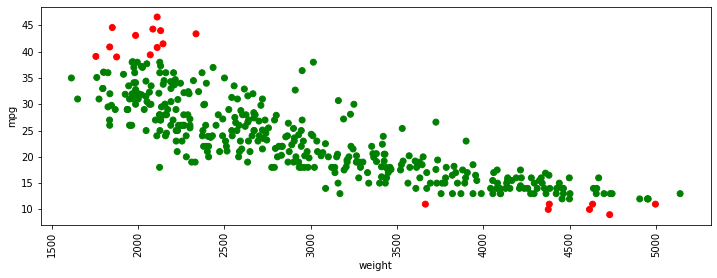

In [ ]:
knn_data = model_fit(KNN_model, data)
plot_anom(knn_data)

### Removing the data points considered outliers by the KNN model

In [ ]:
#Removing data points considered anomalies by KNN
knn_data = knn_data.drop(knn_data[knn_data['Predictions'] == 1].index)
knn_data = knn_data.drop(columns=['Predictions'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


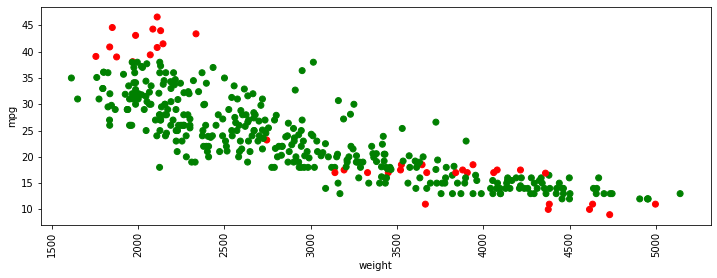

In [ ]:
LOF_model = LOF()
lof_data = model_fit(LOF_model, data)
plot_anom(lof_data)

### Removing the data points considered outliers by the LOF model

In [ ]:
#Removing data points considered anomalies by LOF
lof_data = lof_data.drop(lof_data[lof_data['Predictions'] == 1].index)
lof_data = lof_data.drop(columns=['Predictions'])

In [ ]:
knn_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,15.0,8,350.0,165.0,3693.0,11.5,70,1
1,18.0,8,318.0,150.0,3436.0,11.0,70,1
2,16.0,8,304.0,150.0,3433.0,12.0,70,1
3,17.0,8,302.0,140.0,3449.0,10.5,70,1
4,15.0,8,429.0,198.0,4341.0,10.0,70,1


In [ ]:
mpg_max = knn_data.mpg.max()
mpg_min = knn_data.mpg.min()
print("max:",mpg_max)
print("min:",mpg_min)

max: 38.1
min: 12.0


### Binning the MPG values into mpg_cat, out created class label

0    199
1    179
Name: mpg_cat, dtype: int64


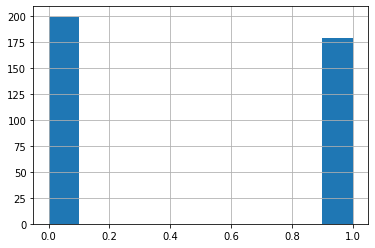

In [ ]:
mpgM = knn_data['mpg'].mean()

knn_data['mpg_cat'] = pd.cut(knn_data['mpg']
                              , bins=[0,mpgM,mpg_max]
                              , labels=[0,1])
knn_data["mpg_cat"].hist()
print(knn_data["mpg_cat"].value_counts())

### Viewing the ammount of data points in each catagory with under sampling. only 179 in each

In [ ]:
# class count
count_class_LH, count_class_UH = knn_data.mpg_cat.value_counts()
# Divide by class
data_class_LH = knn_data[knn_data['mpg_cat']== 0]
data_class_UH = knn_data[knn_data['mpg_cat']== 1]

Random under-sampling:
0    179
1    179
Name: mpg_cat, dtype: int64


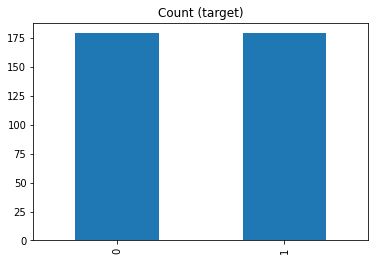

In [ ]:
data_class_LH_under = data_class_LH.sample(count_class_UH)
data_under = pd.concat([data_class_LH_under, data_class_UH], axis=0)

print('Random under-sampling:')
print(data_under.mpg_cat.value_counts())

data_under.mpg_cat.value_counts().plot(kind='bar', title='Count (target)');

## SMOTE for over sample

### Using SMOTE, 199 data points are available for each catagory of our class label. This will be invaluable given the small nature of the data set

SMOTE over sampling:
0    199
1    199
Name: mpg_cat, dtype: int64


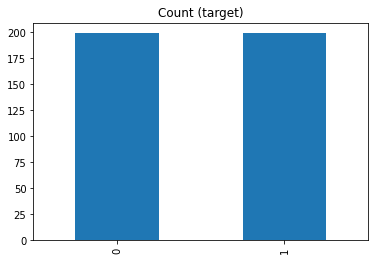

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

X = knn_data.drop(['mpg_cat'], axis=1)
y = knn_data.mpg_cat

features_X, target_y = oversample.fit_resample(X, y)

print('SMOTE over sampling:')
print(target_y.value_counts())
target_y.value_counts().plot(kind='bar', title='Count (target)');

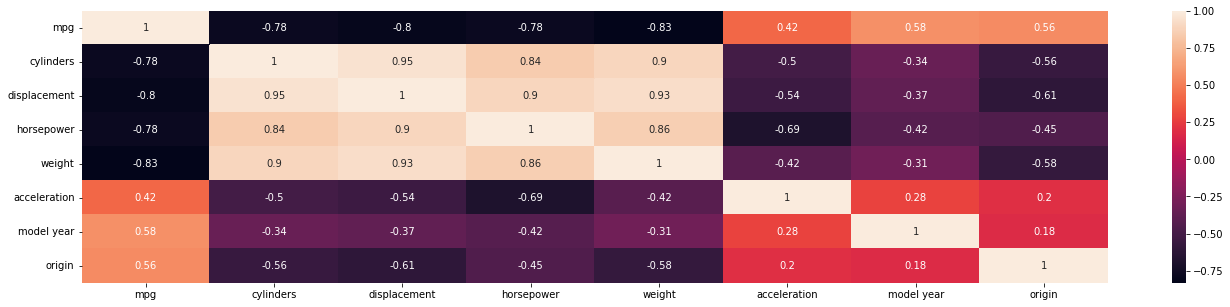

In [ ]:
plt.figure(figsize=(23,5))
sns.heatmap(data=data.corr(), annot=True);

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
import pandas as pd

# Principle Componant Analysis (PCA) for feature selection

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# initializing standard scaler.
scaler = StandardScaler()     

In [ ]:
#droping MPG, as it is directly related to mpg_cat
data_under = knn_data.drop(columns=['mpg'])

droped_data = data_under.copy()
output_data = droped_data.loc[:, ['mpg_cat']]
droped_data = droped_data.drop(columns=['mpg_cat'])
# Scaling the PCA
droped_data_scaled = droped_data.copy()
droped_data_scaled[droped_data_scaled.columns] = scaler.fit_transform(droped_data_scaled)

In [ ]:
data_under.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,mpg_cat
0,8,350.0,165.0,3693.0,11.5,70,1,0
1,8,318.0,150.0,3436.0,11.0,70,1,0
2,8,304.0,150.0,3433.0,12.0,70,1,0
3,8,302.0,140.0,3449.0,10.5,70,1,0
4,8,429.0,198.0,4341.0,10.0,70,1,0


In [ ]:
# Selecting one component
pca = PCA(n_components=1)

#selecting 3 attributes to get a combination
a_dict = dict()   # dictionary to hold the variance of group of attributes        dict[attributes-name] = 1st PCA comp

# Three attribute group
for i in range (len(droped_data_scaled.columns) - 2):
    for j in range (i+1, len(droped_data_scaled.columns) - 1):
        for k in range (j+1, len(droped_data_scaled.columns) - 0):
            input_cols = [droped_data_scaled.columns[i], droped_data_scaled.columns[j], droped_data_scaled.columns[k]]
            col_str = "" + droped_data_scaled.columns[i] + "," + droped_data_scaled.columns[j] + "," + droped_data_scaled.columns[k]
            pca_strength = pca.fit_transform(droped_data_scaled[input_cols]) # applying the PCA
            variance = np.round(pca.explained_variance_ratio_, decimals=3) * 100 # variance on the first component
            print(col_str,  "=" , variance)
            a_dict[col_str] = variance

cylinders,displacement,horsepower = [93.1]
cylinders,displacement,weight = [94.9]
cylinders,displacement,acceleration = [78.2]
cylinders,displacement,model year = [70.8]
cylinders,displacement,origin = [80.5]
cylinders,horsepower,weight = [90.8]
cylinders,horsepower,acceleration = [78.9]
cylinders,horsepower,model year = [68.3]
cylinders,horsepower,origin = [74.4]
cylinders,weight,acceleration = [74.2]
cylinders,weight,model year = [67.9]
cylinders,weight,origin = [78.5]
cylinders,acceleration,model year = [57.2]
cylinders,acceleration,origin = [61.3]
cylinders,model year,origin = [56.5]
displacement,horsepower,weight = [93.]
displacement,horsepower,acceleration = [81.1]
displacement,horsepower,model year = [70.4]
displacement,horsepower,origin = [77.]
displacement,weight,acceleration = [75.9]
displacement,weight,model year = [69.4]
displacement,weight,origin = [80.5]
displacement,acceleration,model year = [58.6]
displacement,acceleration,origin = [63.3]
displacement,model year,origin 

In [ ]:
import operator
# sorting the dictionary
sorted_dict = {k: v for k, v in sorted(a_dict.items(), key=lambda item: item[1])}
single_a_dict = dict()

count = 0

# using the first 100
for key in sorted_dict:  
    temp = key.split(",")  # key split to see attributes
    for val in temp:       # for each attribute, count how many times it is present in the ammount specified
        if val in single_a_dict:
            single_a_dict[val] += 1
        else:
            single_a_dict[val] = 1
    if count == 20:
        break
    count+=1

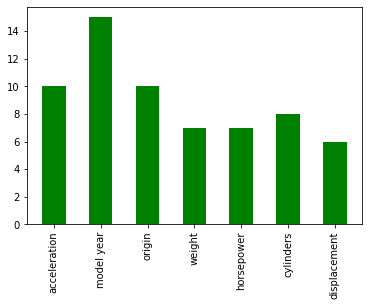

In [ ]:
#Using bargraph to visualise

df = pd.DataFrame([single_a_dict])


plt.xticks(rotation='vertical')
plt.bar(single_a_dict.keys(), single_a_dict.values(), width=0.5, color='g')
value_counts = len(single_a_dict)

In [ ]:
df.head()

,acceleration,model year,origin,weight,horsepower,cylinders,displacement
0,10,15,10,7,7,8,6


In [ ]:
data_items = single_a_dict.items()
data_list = list(data_items)

df = pd.DataFrame(data_list)

In [ ]:
df.head()

,0,1
0,acceleration,10
1,model year,15
2,origin,10
3,weight,7
4,horsepower,7


In [ ]:
df.columns=['key','value']

In [ ]:
value_cut_off_point = 7

df.loc[df['value'] <= value_cut_off_point, 'key']

3          weight
4      horsepower
6    displacement
Name: key, dtype: object

In [ ]:
PCA_remove_count = len(df.loc[df['value'] <= 7, 'key'])
print(PCA_remove_count)

3


In [ ]:
data_under.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,mpg_cat
0,8,350.0,165.0,3693.0,11.5,70,1,0
1,8,318.0,150.0,3436.0,11.0,70,1,0
2,8,304.0,150.0,3433.0,12.0,70,1,0
3,8,302.0,140.0,3449.0,10.5,70,1,0
4,8,429.0,198.0,4341.0,10.0,70,1,0


In [ ]:
i = 0
while i < PCA_remove_count:
  x = df.loc[df['value'] <= 7, 'key'].iloc[i]
  data_under = data_under.drop(columns=[x])
  i = i + 1

In [ ]:
data_under.head()

,cylinders,acceleration,model year,origin,mpg_cat
0,8,11.5,70,1,0
1,8,11.0,70,1,0
2,8,12.0,70,1,0
3,8,10.5,70,1,0
4,8,10.0,70,1,0


SMOTE over sampling:
0    199
1    199
Name: mpg_cat, dtype: int64


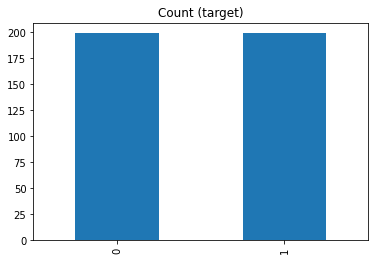

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

X = data_under.drop(['mpg_cat'], axis=1)
y = data_under.mpg_cat

features_X, target_y = oversample.fit_resample(X, y)

print('SMOTE over sampling:')
print(target_y.value_counts())
target_y.value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
X.head()

,cylinders,acceleration,model year,origin
0,8,11.5,70,1
1,8,11.0,70,1
2,8,12.0,70,1
3,8,10.5,70,1
4,8,10.0,70,1


In [ ]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: mpg_cat, dtype: category
Categories (2, int64): [0 < 1]

In [ ]:
data_final = data_under.copy()


X = pd.DataFrame(features_X, columns=features_X.columns)



y = pd.DataFrame(target_y)

In [ ]:
X.head()

,cylinders,acceleration,model year,origin
0,8,11.5,70,1
1,8,11.0,70,1
2,8,12.0,70,1
3,8,10.5,70,1
4,8,10.0,70,1


In [ ]:
y.head()

,mpg_cat
0,0
1,0
2,0
3,0
4,0


In [ ]:
print(y.value_counts())

mpg_cat
0          199
1          199
dtype: int64


In [ ]:
import statsmodels.api as stat
from statsmodels.stats.outliers_influence import variance_inflation_factor 



#VIF calculation
VIFcalc = stat.tools.add_constant(X)
S = pd.Series([variance_inflation_factor(VIFcalc.values, i) for i in range(VIFcalc.shape[1])], index=VIFcalc.columns)
print('Output: \n\n{}\n'.format(S))

#print('Recomended removal:')
#for x in S.index:
 # if S.loc[x]> 10:
 #   print(str(x))
 #   if x != 'const':
 #     data_final = data_final.drop(columns=[str(x)])


Output: 

const           608.925013
cylinders         1.867866
acceleration      1.330273
model year        1.121007
origin            1.430969
dtype: float64



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.80, 
                                                    random_state=1,
                                                    stratify=y)

In [ ]:
print('X_train shape', y_train.shape, 'X_test shape', y_test.shape)

X_train shape (318, 1) X_test shape (80, 1)


In [ ]:
print('train_class_one_ratio', np.count_nonzero(y_train==1) / len(y_train))
print('test_class_one_ratio', np.count_nonzero(y_test==1) / len(y_test))

train_class_one_ratio 0.5
test_class_one_ratio 0.5


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier

def stacking():
  # Including the different models to be used for stacking, base level L0
	L0 = []
	L0.append(('KNN', KNeighborsClassifier()))
	L0.append(('CART', DecisionTreeClassifier()))
	L0.append(('NB', GaussianNB()))
	L0.append(('SVM', SVC(gamma='auto')))
	L0.append(('LR', LogisticRegression(max_iter=10000)))
	L0.append(('SGDClassifier', SGDClassifier(loss="hinge", penalty="l2", max_iter=10000)))
	L0.append(('RandomForestClassifier', RandomForestClassifier(n_estimators=10)))
	L0.append(('AdaBoostClassifier', AdaBoostClassifier(n_estimators=100)))
	# Define meta learner model as L1
	L1 = LogisticRegression(max_iter=10000)
	# Define the stacking ensemble
	model = StackingClassifier(estimators=L0, final_estimator=L1, cv=10)
	return model

# Spot Check Algorithms for class_label classification
pred_models = []
pred_models.append(('KNN', KNeighborsClassifier()))
pred_models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
pred_models.append(('GaussianNB', GaussianNB()))
pred_models.append(('SupportVectorMachine', SVC(gamma='auto')))
pred_models.append(('LogisticRegression', LogisticRegression(max_iter=10000)))
pred_models.append(('SGDClassifier', SGDClassifier(loss="hinge", penalty="l2", max_iter=10000)))
pred_models.append(('RandomForestClassifier', RandomForestClassifier(n_estimators=10)))
pred_models.append(('AdaBoostClassifier', AdaBoostClassifier(n_estimators=100)))
pred_models.append(('RandomForestClassifierOPTIMISED', RandomForestClassifier(bootstrap=True, max_depth=110, max_features= 'sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=1000)))

#Stacking model 
pred_models.append(('Stacking', stacking()))


# evaluate each model, one after another.Uses 5-fold cross validation
results = []
names = []
for name, model in pred_models:
	skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
	cross_val_results = cross_val_score(model, X_train, y_train.values.ravel(), cv=skf, scoring='accuracy')
	results.append(cross_val_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cross_val_results.mean(), cross_val_results.std()))




# Comparison of the different models:

KNN: 0.915179 (0.043690)
DecisionTreeClassifier: 0.902480 (0.044040)
GaussianNB: 0.902530 (0.031819)
SupportVectorMachine: 0.912054 (0.028841)
LogisticRegression: 0.896329 (0.025040)
SGDClassifier: 0.870734 (0.082666)
RandomForestClassifier: 0.912103 (0.032063)
AdaBoostClassifier: 0.896131 (0.016627)
RandomForestClassifierOPTIMISED: 0.918254 (0.033744)
Stacking: 0.912103 (0.030297)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


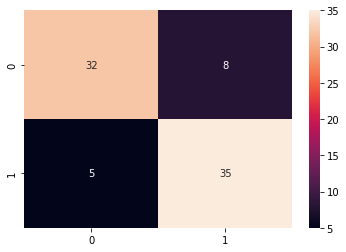

In [ ]:
stack = stacking()
stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm2, annot=True, fmt=".0f")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        40
           1       0.81      0.88      0.84        40

    accuracy                           0.84        80
   macro avg       0.84      0.84      0.84        80
weighted avg       0.84      0.84      0.84        80



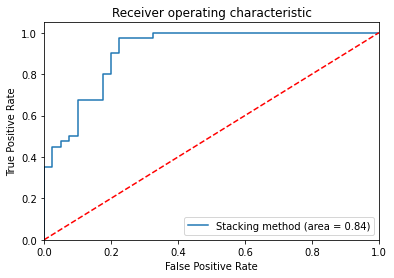

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
stack_roc_auc = roc_auc_score(y_test, stack.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, stack.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Stacking method (area = %0.2f)' % stack_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


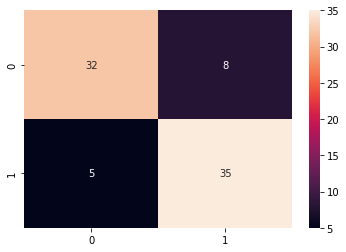

In [ ]:
RFO = RandomForestClassifier(bootstrap=True, max_depth=110, max_features= 'sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=1000)
RFO.fit(X_train, y_train)
y_pred = RFO.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm2, annot=True, fmt=".0f")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        40
           1       0.81      0.88      0.84        40

    accuracy                           0.84        80
   macro avg       0.84      0.84      0.84        80
weighted avg       0.84      0.84      0.84        80



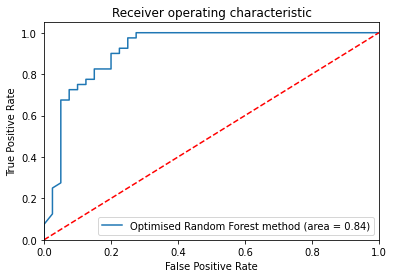

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
RFO_roc_auc = roc_auc_score(y_test, RFO.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, RFO.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Optimised Random Forest method (area = %0.2f)' % RFO_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


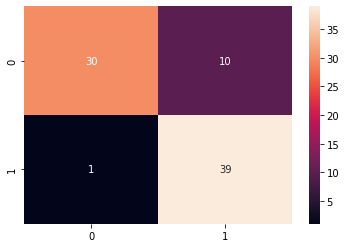

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm2, annot=True, fmt=".0f")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.75      0.85        40
           1       0.80      0.97      0.88        40

    accuracy                           0.86        80
   macro avg       0.88      0.86      0.86        80
weighted avg       0.88      0.86      0.86        80



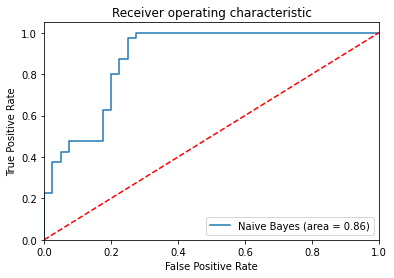

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
nb_roc_auc = roc_auc_score(y_test, nb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, nb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Naive Bayes (area = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

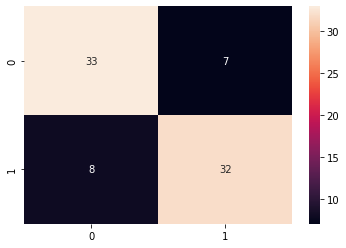

In [ ]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
cm1 = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm1, annot=True, fmt=".0f")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81        40
           1       0.82      0.80      0.81        40

    accuracy                           0.81        80
   macro avg       0.81      0.81      0.81        80
weighted avg       0.81      0.81      0.81        80



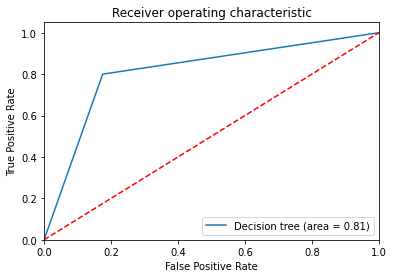

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
dt_roc_auc = roc_auc_score(y_test, dt.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, dt.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision tree (area = %0.2f)' % dt_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


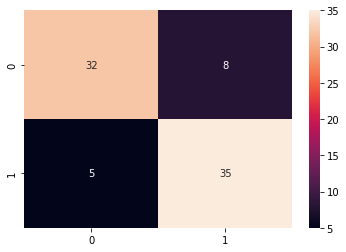

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm2, annot=True, fmt=".0f")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        40
           1       0.81      0.88      0.84        40

    accuracy                           0.84        80
   macro avg       0.84      0.84      0.84        80
weighted avg       0.84      0.84      0.84        80



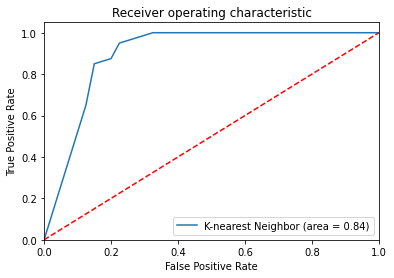

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
knn_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='K-nearest Neighbor (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


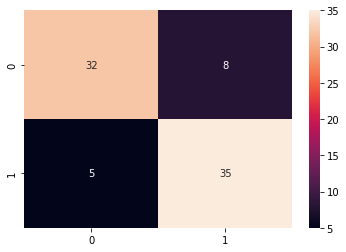

In [ ]:
SVM = SVC(gamma='auto')
SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm2, annot=True, fmt=".0f")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        40
           1       0.81      0.88      0.84        40

    accuracy                           0.84        80
   macro avg       0.84      0.84      0.84        80
weighted avg       0.84      0.84      0.84        80



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


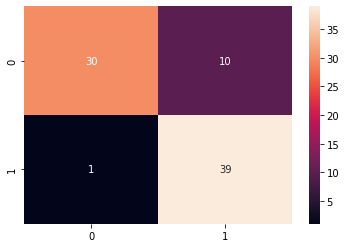

In [ ]:
LOGR = LogisticRegression()
LOGR.fit(X_train, y_train)
y_pred = nb.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm2, annot=True, fmt=".0f")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.75      0.85        40
           1       0.80      0.97      0.88        40

    accuracy                           0.86        80
   macro avg       0.88      0.86      0.86        80
weighted avg       0.88      0.86      0.86        80



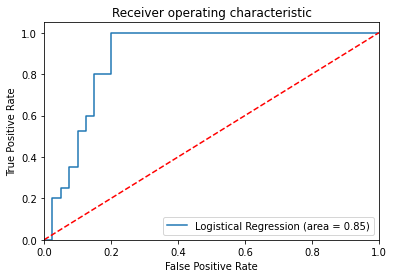

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
LOGR_roc_auc = roc_auc_score(y_test, LOGR.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, LOGR.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistical Regression (area = %0.2f)' % LOGR_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


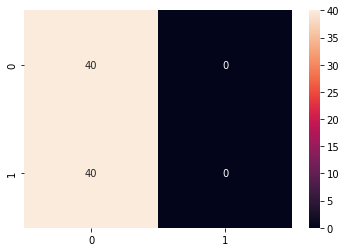

In [ ]:
SGD = SGDClassifier(loss="hinge", penalty="l2", max_iter=10000)
SGD.fit(X_train, y_train)
y_pred = SGD.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm2, annot=True, fmt=".0f")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        40
           1       0.00      0.00      0.00        40

    accuracy                           0.50        80
   macro avg       0.25      0.50      0.33        80
weighted avg       0.25      0.50      0.33        80



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


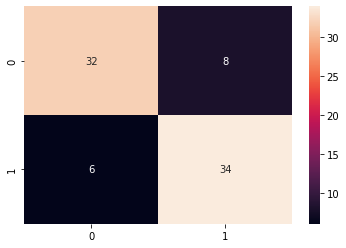

In [ ]:
ADA = AdaBoostClassifier(n_estimators=100)
ADA.fit(X_train, y_train)
y_pred = ADA.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm2, annot=True, fmt=".0f")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82        40
           1       0.81      0.85      0.83        40

    accuracy                           0.82        80
   macro avg       0.83      0.82      0.82        80
weighted avg       0.83      0.82      0.82        80



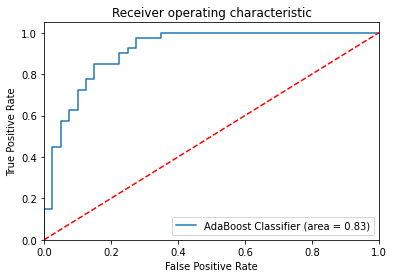

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
ADA_roc_auc = roc_auc_score(y_test, ADA.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, ADA.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AdaBoost Classifier (area = %0.2f)' % ADA_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


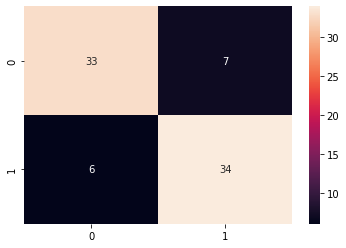

In [ ]:
RF = RandomForestClassifier(n_estimators=10)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm2, annot=True, fmt=".0f")

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84        40
           1       0.83      0.85      0.84        40

    accuracy                           0.84        80
   macro avg       0.84      0.84      0.84        80
weighted avg       0.84      0.84      0.84        80



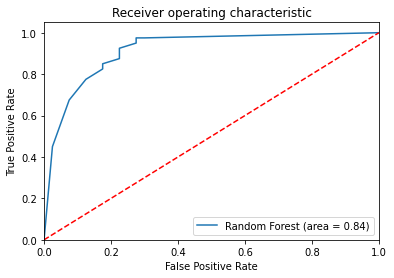

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
RF_roc_auc = roc_auc_score(y_test, RF.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, RF.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % RF_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Using best model with sklearn's RandomizedSearchCV, which trys to find the best parameters which yeild the most accurate results
* Step 1: Create random grid of params to use
* Step 2: Uses RandomizedSearchCV with the params we selected to be in the random grid, with 3-fold crossvalidation
* Step 3: Prints out the parameters that had the highest prediction accuracy

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Tree count
estimator_number = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
#  # of Features at split
max_features = ['auto', 'sqrt']
# Tree levels
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Min # of samples required to split at node
min_samples_split = [2, 5, 10]
# Min # of samples required at leaf nodes
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
RG = {'n_estimators': estimator_number,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(RG)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
#Sets the model we are testsing diff params on
##rf = RandomForestClassifier()
# Starts random search for the best params
# Uses 100 different combinations, with 3-fold cross validation
##rf_best_params = RandomizedSearchCV(estimator = rf, param_distributions = RG, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit
##rf_best_params.fit(X_train, y_train)

In [ ]:
##rf_best_params.best_params_

## Deep Learning using Keras. 4 node input layer with 8 and 4 node hidden layers

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json

# define the keras model
model = Sequential()
model.add(Dense(8, input_dim=4, activation='relu'))
model.add(Dense(4, activation='relu'))


model.add(Dense(1, activation='sigmoid'))
# compile the keras model (binary_crossentropy)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=100, batch_size=10)
# evaluate the keras model
_, accuracy = model.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))



#Saving the model (serialize to JSON)
model_saved = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_saved)
# serialize weights to HDF5
model.save_weights("model.h5")
print('MODEL SAVED')

Epoch 1/100
32/32 [==============================] - 1s 1ms/step - loss: 0.7369 - accuracy: 0.4434
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 0.7172 - accuracy: 0.4403
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6984 - accuracy: 0.5126
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - loss: 0.6819 - accuracy: 0.5597
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6661 - accuracy: 0.5912
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6545 - accuracy: 0.6352
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6395 - accuracy: 0.6478
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6166 - accuracy: 0.7170
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6136 - accuracy: 0.6918
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 0.5967 - accuracy: 0.7107
Epoch 11/

## Loading the Deep Learning model and testing on unseen data

In [ ]:
# loading model to predict on test set
j_file = open('model.json', 'r')
json = j_file.read()
j_file.close()
model = model_from_json(json)
# load weights into new model
model.load_weights("model.h5")
print("loaded correctly")
 
# evaluate loaded model on test data
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

loaded correctly
accuracy: 86.25%
